In [1]:
import numpy as np

from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import torch
import torchvision

import cv2
import json

from functools import partial

import urllib

In [2]:
class_idx = json.load(open('imagenet_class_index.json','r'))

# Load sample image

In [3]:
urllib.request.urlretrieve("https://i.imgur.com/Bvro0YD.png", "african_elephant.jpg")

('african_elephant.jpg', <http.client.HTTPMessage at 0x7fdc143fe8e0>)

In [4]:
img = cv2.imread("african_elephant.jpg")
img = cv2.resize(img, dsize=(299,299))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

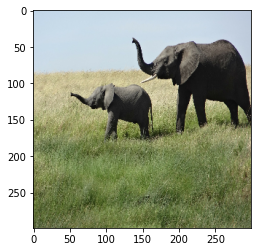

In [5]:
plt.imshow(img)

# The Grad-CAM algorithm

![image](https://user-images.githubusercontent.com/37654013/112749341-b3712780-8ffc-11eb-97ff-4001007c290d.png)


In [6]:
class GradCAM(object):
    '''
    Gradient Class Activation Map (Grad-CAM)
    '''
    def __init__(self, model, layer_name):
        # seqeuntial name
        self.layer_name = layer_name
        # model
        self.model = model
        # evaluation mode
        self.model.eval()
        # hook
        self.hook_layers()
        # initial dicts
        self.conv_outputs = {}
        self.gradients = {}
    
    def hook_layers(self):
        def hook_forward(module, input, output, key):
            self.conv_outputs[key] = output

        def hook_backward(module, input, output, key):
            self.gradients[key] = output[0]

        for idx, layer in enumerate(self.model._modules.get(self.layer_name)):
            layer.register_forward_hook(partial(hook_forward, key=idx))
            layer.register_backward_hook(partial(hook_backward, key=idx))
            
    def generate_image(self, pre_imgs, idx, targets=None):    
        # prediction
        pre_imgs = torch.autograd.Variable(pre_imgs, requires_grad=True)
        outputs = self.model(pre_imgs)
        outputs_softmax = torch.nn.functional.softmax(outputs, dim=1)
        probs, preds = outputs_softmax.detach().max(1)

        # convert target type to LongTensor
        if targets is not None:
            targets = torch.LongTensor([targets])
        else:
            targets = preds
        
        one_hot_output = torch.zeros_like(outputs).scatter(1, targets.unsqueeze(1), 1).detach()
        outputs.backward(gradient=one_hot_output)

        gradients = self.gradients[idx].numpy()
        
        # A = w * conv_output
        convs = self.conv_outputs[idx].detach().numpy()
        weights = np.mean(gradients, axis=(2,3))
        weights = weights.reshape(weights.shape + (1,1,))

        gradcams = weights * convs
        gradcams = gradcams.sum(axis=1)

        # relu
        gradcams = np.maximum(gradcams, 0)
        
        return gradcams, probs.numpy(), preds.numpy()

In [7]:
def preprocessing_image(image):
    transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=[0,0,0],
                                         std=[1,1,1])
    ])

    pre_img = transform(img)
    
    if len(pre_img.size())==3:
        pre_img = pre_img.unsqueeze(0)

    return pre_img

# Let's test-drive it

In [8]:
img = cv2.imread("african_elephant.jpg")
img = cv2.resize(img, dsize=(299,299))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [9]:
model = torchvision.models.resnet50(pretrained=True)
layer_name = 'layer4'
pre_img = preprocessing_image(img)

In [10]:
gradcam = GradCAM(model, layer_name)

In [11]:
heatmaps, probs, preds = gradcam.generate_image(pre_img, 2)

In [12]:
print(f'Predicted: [{class_idx[str(preds[0])]}: {probs[0]:.4%}]')

Predicted: [['n02504458', 'African_elephant']: 86.7550%]


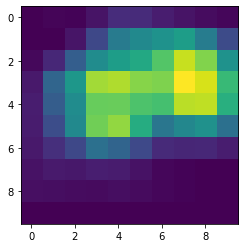

In [13]:
plt.imshow(heatmaps[0])

# Create a superimposed visualization

In [14]:
def display_gradcam_with_image(img_path, heatmap, cam_path='cam.jpg', alpha=0.4):
    # Load the original image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Rescale 0~1 and Resize heatmap by the original image size
    heatmap = heatmap / heatmap.max()
    heatmap = cv2.resize(heatmap, dsize=(img.shape[1], img.shape[0]))
    
    # Use jet colormap to colorize heatmap
    heatmap = cv2.applyColorMap(np.uint8(heatmap * 255), cv2.COLORMAP_JET)
    
    # Rescale heatmap and the original image range 0~1
    heatmap = np.float32(heatmap) / 255
    img = np.float32(img) / 255
    
    # Superimpose the heatmap on original image
    superimposed_img = heatmap * alpha + img
    superimposed_img = superimposed_img / superimposed_img.max()
    superimposed_img = np.uint8(superimposed_img*255)

    # Save the superimposed image
    cv2.imwrite(cam_path, superimposed_img)
    
    # display grad cam
    display(Image(cam_path))

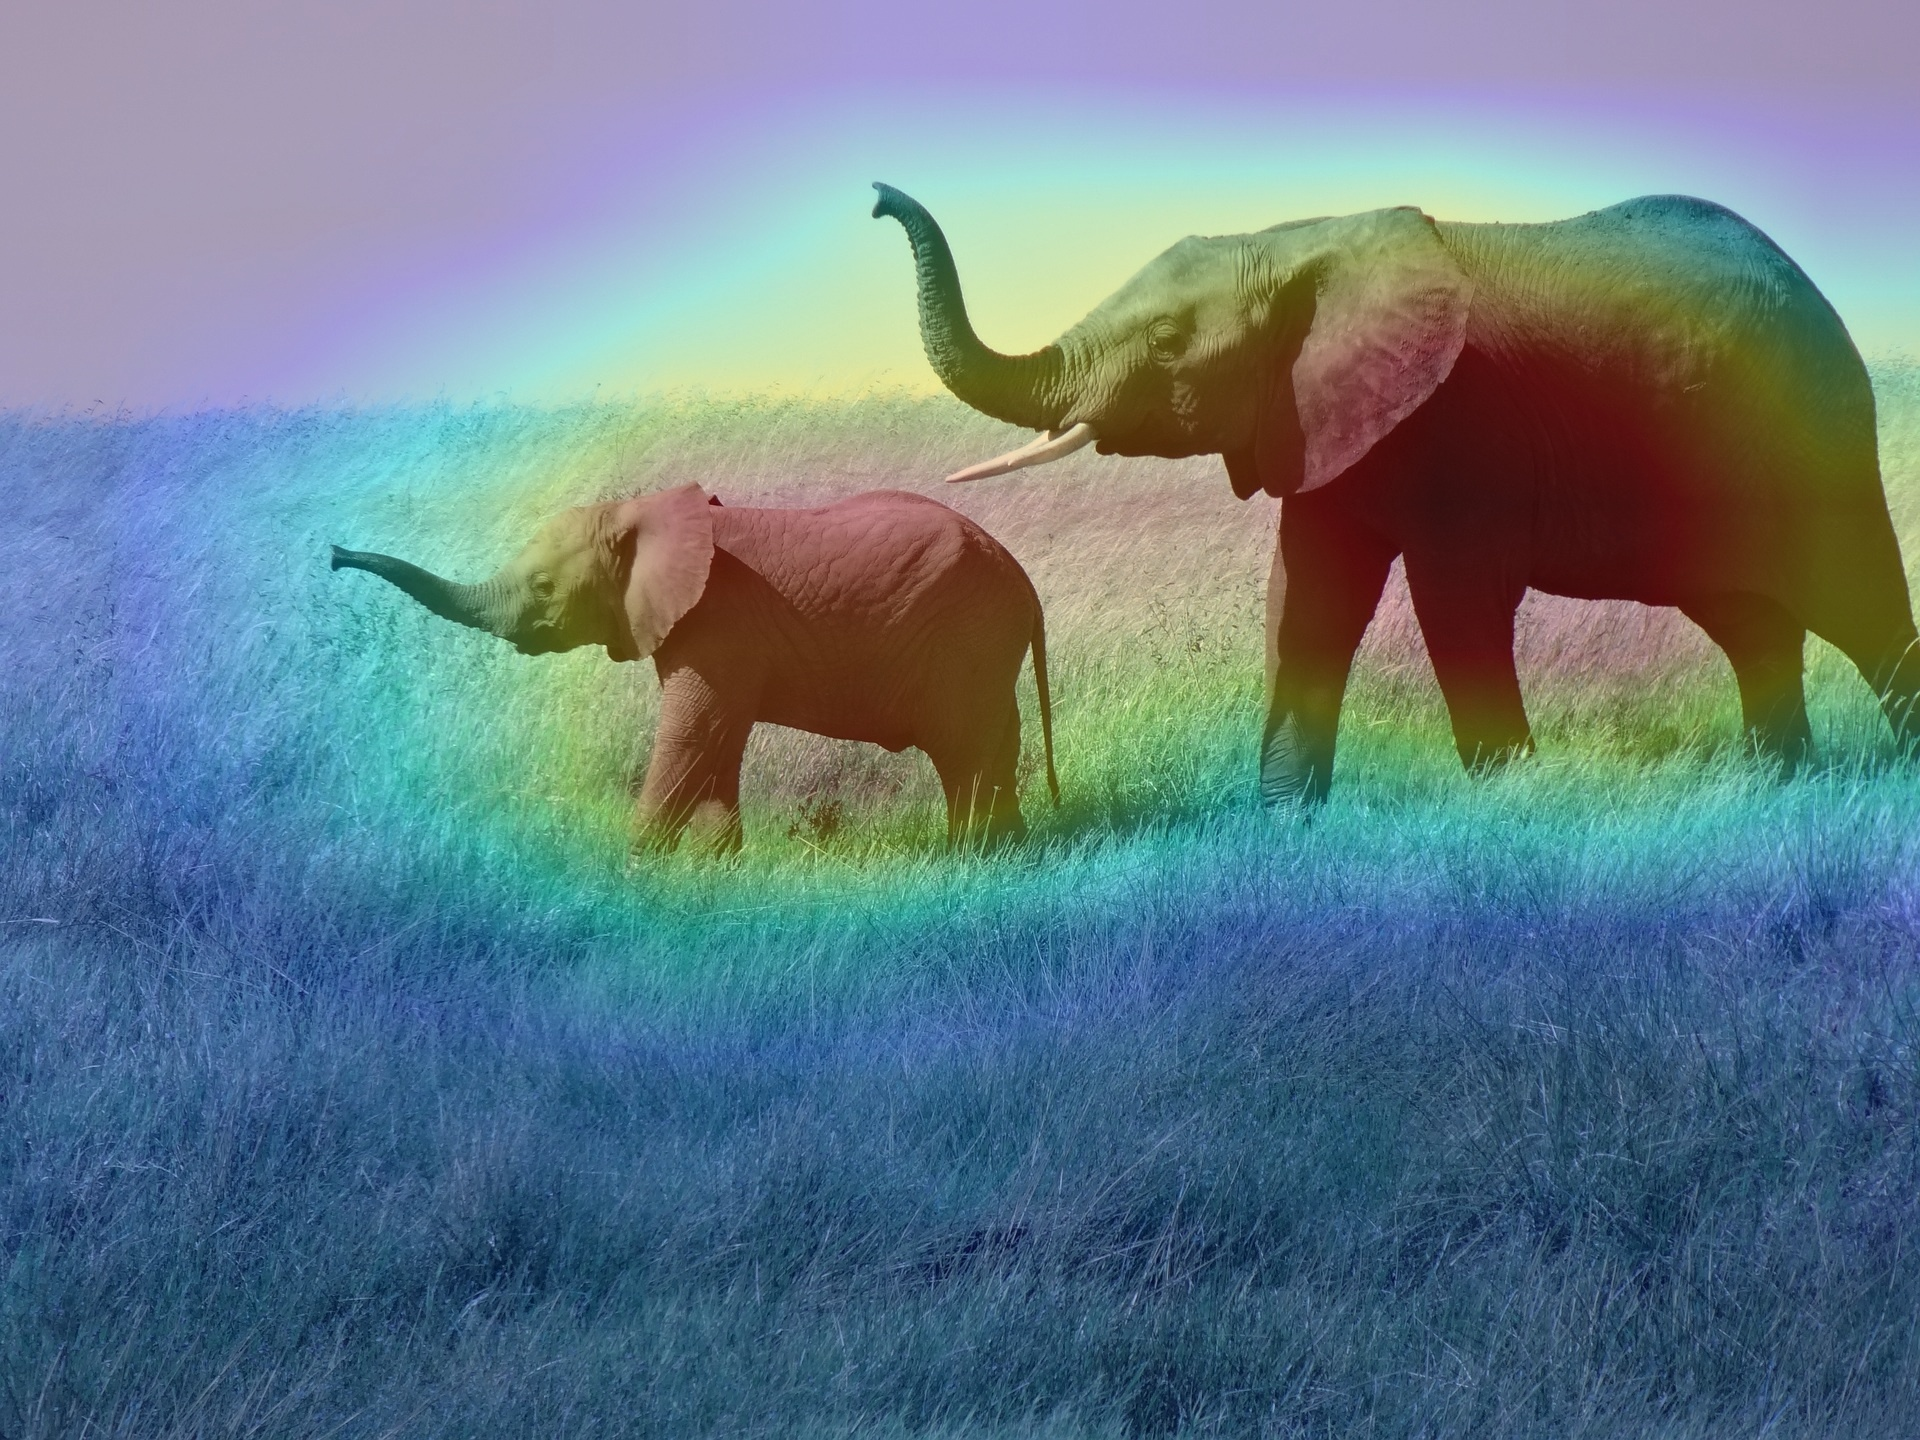

In [15]:
display_gradcam_with_image(img_path='african_elephant.jpg',
                           heatmap=heatmaps[0])

# Let's try another image

We will see how the grad cam explains the model's outputs for a multi-label image. Let's try an image with a cat and a dog together, and see how the grad cam behaves.

In [16]:
urllib.request.urlretrieve("https://storage.googleapis.com/petbacker/images/blog/2017/dog-and-cat-cover.jpg", 
                           "cat_and_dog.jpg")

('cat_and_dog.jpg', <http.client.HTTPMessage at 0x7fdb33725a90>)

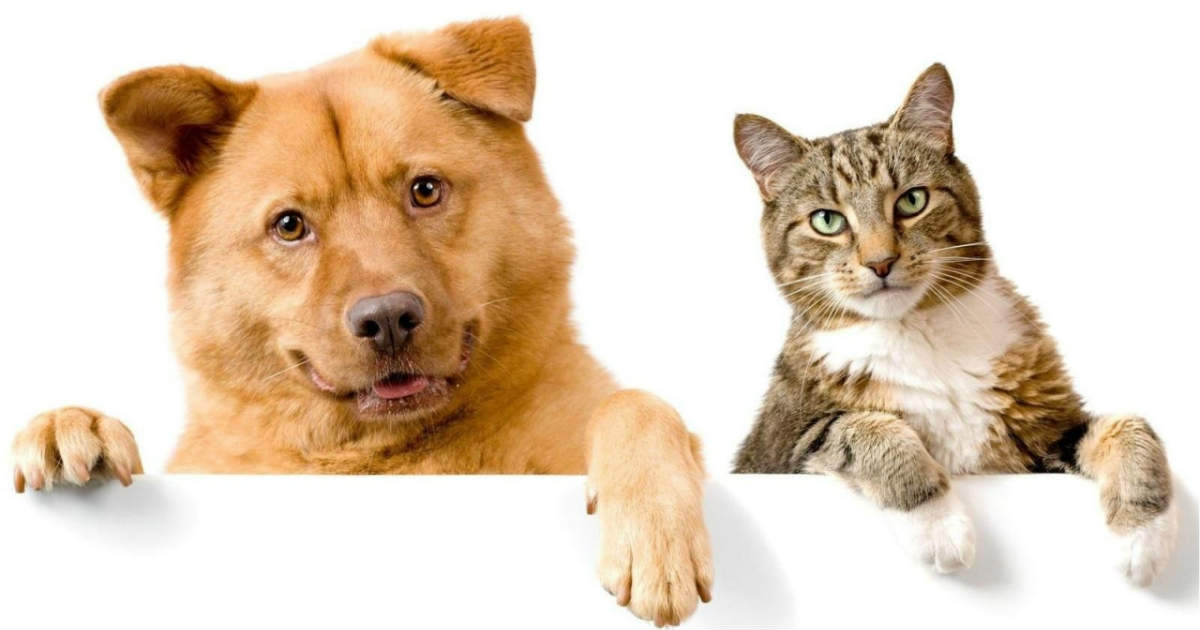

In [17]:
display(Image("cat_and_dog.jpg"))

In [18]:
img = cv2.imread('cat_and_dog.jpg')
img = cv2.resize(img, dsize=(299,299))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

pre_img = preprocessing_image(img)

In [19]:
outputs = model(pre_img)
outputs_softmax = torch.nn.functional.softmax(outputs, dim=1)
probs, preds = torch.topk(outputs_softmax, k=2)
probs, preds = probs[0].detach().numpy(), preds[0].detach().numpy()

In [20]:
print(f'Predicted: [{class_idx[str(preds[0])]}: {probs[0]:.4%}], [{class_idx[str(preds[1])]}: {probs[1]:.4%}]')

Predicted: [['n02134084', 'ice_bear']: 10.1307%], [['n02114548', 'white_wolf']: 7.3232%]


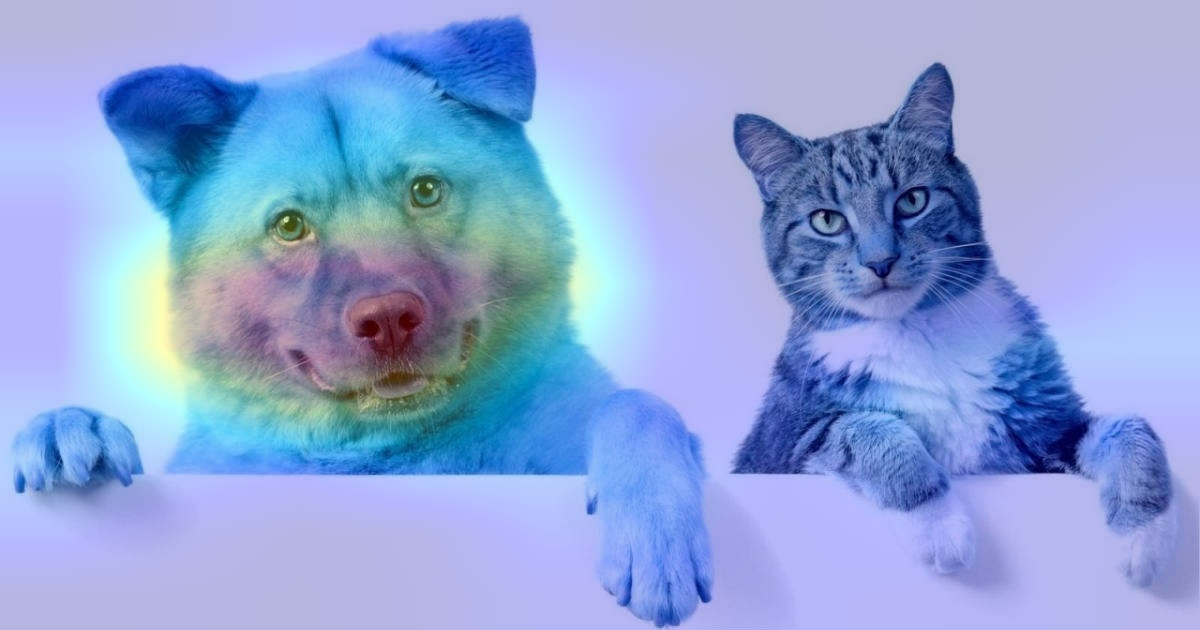

In [21]:
heatmaps, probs, preds = gradcam.generate_image(pre_img, 2, targets=260)
display_gradcam_with_image(img_path='cat_and_dog.jpg',
                           heatmap=heatmaps[0])

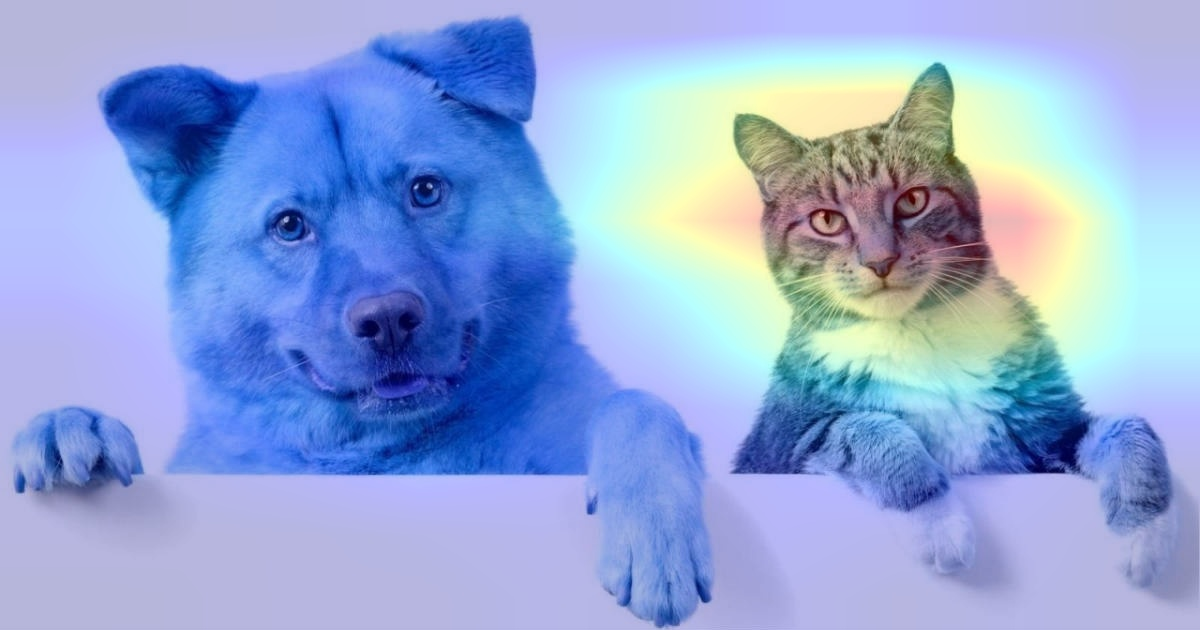

In [22]:
heatmaps, probs, preds = gradcam.generate_image(pre_img, 2, targets=285)
display_gradcam_with_image(img_path='cat_and_dog.jpg',
                           heatmap=heatmaps[0])